### Part 3: Machine Learning for Healthier Food Recommendations

#### Introduction
This section focuses on leveraging machine learning and ranking models to provide personalized healthier food recommendations. The process involves designing algorithms to calculate product similarity and identify healthier alternatives while considering user-defined constraints and preferences. By integrating clustering, ranking, and filtering techniques, we aim to ensure the recommendations are not only similar but also align with nutritional and health-focused goals.

#### Key Points:
- **Data Preparation**:
  - Numeric, categorical, and textual food features are extracted and preprocessed.
  - KMeans clustering is used to group similar food items based on numeric features.

- **Similarity Calculation**:
  - The KMeans clustering algorithm helps identify clusters of similar food products.
  - LightGBM's LambdaMART model ranks similar items based on nutritional score and user preferences.

- **Constraint-Based (User-defined) Filtering**:
  - User-defined constraints are applied to filter recommendations.
  - Constraints include conditions like "higher nutritional score," "lower fat," or "similar energy levels."

- **Recommendation Pipeline**:
  - For each item in the user's shopping list:
    1. Identify the cluster containing the item.
    2. Filter out items from the same cluster based on constraints.
    3. Rank the remaining items using the LambdaMART model.
    4. Provide top recommendations.

- **Modeling Techniques**:
  - **KMeans Clustering**: Groups products based on numeric features to identify initial candidates.
  - **LambdaMART Ranking**: Refines recommendations using gradient boosting to prioritize healthier options.
  - **Custom Filtering Function**: Ensures user-defined constraints guide the recommendation process.

#### Implementation Goals:
- Build a robust and scalable pipeline to recommend healthier food alternatives.
- Tailor recommendations to individual preferences and nutritional needs.
- Balance similarity with health-focused constraints to optimize user satisfaction.

#### Challenges:
- Balancing multiple constraints without overly restricting the pool of candidates.
- Ensuring the recommendations maintain similarity while adhering to health guidelines.
- Handling diverse product features and missing data in the Open Food Facts database.

By combining clustering, ranking, and user-defined filtering, this system offers a comprehensive approach to personalized food recommendations, promoting healthier choices and improved public health outcomes.


### Imported Libraries and Dependencies

#### Data Handling and Preprocessing
- `numpy`, `pandas`: Essential libraries for handling numerical data and structured datasets.
- `matplotlib.pyplot`, `seaborn`: Visualization libraries to generate plots and charts for data analysis.
- `warnings`: Used to suppress unnecessary warnings during execution.

#### Machine Learning Models and Utilities
- `sklearn.neighbors.NearestNeighbors`: Finds nearest neighbors for similarity calculations.
- `sklearn.metrics.pairwise.cosine_similarity`: Computes similarity between vectors using cosine metric.
- `sklearn.preprocessing.StandardScaler`: Scales numeric data for uniformity.
- `sklearn.model_selection`: Includes tools like `train_test_split` and `cross_val_score` for model evaluation.
- `sklearn.cluster.KMeans`: Clustering algorithm for grouping similar data points.
- `sklearn.decomposition.PCA`: Dimensionality reduction to project data onto fewer features.
- `lightgbm as lgb`: A fast gradient boosting framework for ranking, classification, and regression tasks.

#### Deep Learning and Tokenization
- `tensorflow.keras.preprocessing.text`, `sequence`: Utilities for tokenizing and padding text sequences.
- `torch`, `torch.nn`: PyTorch library for building and training neural networks.
- `torch.utils.data.DataLoader`, `TensorDataset`: Facilitate batch processing of datasets in PyTorch.

#### Advanced Preprocessing and Encoding
- `sklearn.compose.ColumnTransformer`: Applies transformations to specific columns in a dataset.
- `sklearn.preprocessing`:
  - `MinMaxScaler`, `StandardScaler`, `RobustScaler`: Scale data using different methods.
  - `QuantileTransformer`, `PowerTransformer`: Transform data to follow specific distributions.
  - `OneHotEncoder`: Encodes categorical variables as binary arrays.

#### Additional Utilities
- `gc`: Manages garbage collection to optimize memory usage.
- `random`: Generates random numbers and shuffles data.

#### Suppressed Imports (Commented Out)
- `pytorch_lightning`: Advanced PyTorch utilities for simplifying training loops and callbacks.
- `category_encoders`, `feature_engine`: Libraries for advanced encoding techniques not used here but available for categorical preprocessing.

### Summary
The imports in this code provide a comprehensive suite of tools for:
- **Data preprocessing and scaling**: Scaling, encoding, and transforming raw datasets for machine learning.
- **Machine learning and clustering**: Implementing models like KMeans and LightGBM for clustering and ranking tasks.
- **Deep learning and tokenization**: Preparing and processing text for sequence modeling with TensorFlow and PyTorch.
- **Evaluation and visualization**: Tools to validate model performance and generate insights through visualizations.

These libraries create a robust foundation for implementing machine learning pipelines, especially for tasks involving similarity measurements, ranking, and clustering.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

#keras tokenizer
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence # for import pad_sequences

#pytorch tokenizer
import torch
import torch.nn as nn
# import torchtext

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# import pytorch_lightning as pl
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# from pytorch_lightning.callbacks import ModelSummary, LearningRateMonitor

from sklearn import model_selection

import gc
import random

# import category_encoders as ce
# import feature_engine.encoding as fe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.pipeline import Pipeline

import sklearn.metrics as metrics
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading and Initialization

1. **Food Product Data (`food_fact_df`)**:  
   - A CSV file containing detailed information about various food products, including features such as nutritional values, NOVA score, and health category.

2. **Text Embeddings (`emb_text`)**:  
   - Precomputed embeddings representing food product names. These are loaded from a `.npz` file and stored as a NumPy array (`emb_text_array`).

3. **Ingredient Embeddings (`emb_ingred`)**:  
   - Precomputed embeddings for food product ingredients, also loaded from a `.npz` file and stored as a NumPy array (`emb_ingred_array`).

4. **Shopping List (`shopping_list`)**:  
   - A CSV file representing a user's shopping list, containing product codes and other relevant details.

5. **Indexing for Reference**:  
   - The `food_fact_df` is reset with an added `original_index` column to track items after transformations like splitting or filtering.  
   - The `original_indices` array stores these indices for later use.


In [ ]:
# Load the CSV data file containing food product details
food_fact_df = pd.read_csv('drive/MyDrive/Colab Notebooks/food_fact_withUnhealthScore_withNOVA_withCategory.csv')

# Load precomputed text embeddings (.npz file) for food product names
emb_text = np.load('drive/MyDrive/Colab Notebooks/emb_text_OpenFoodFact545_20241105.npz')
emb_text_array = emb_text['emb']  # Access the 'emb' array containing text embeddings

# Load precomputed ingredient embeddings (.npz file) for food product ingredients
emb_ingred = np.load('drive/MyDrive/Colab Notebooks/emb_ingred_OpenFoodFact545_20241105.npz')
emb_ingred_array = emb_ingred['emb']  # Access the 'emb' array containing ingredient embeddings

# Load the example shopping list file containing product IDs and details
shopping_list = pd.read_csv('drive/MyDrive/Colab Notebooks/example_shopping_list.csv')

# Add original indices to the food_fact_df to keep track of item positions after splitting or filtering
food_fact_df = food_fact_df.reset_index().rename(columns={'index': 'original_index'})

# Extract the original indices for reference during data processing
original_indices = food_fact_df['original_index'].values


### Data Preparation for Training

### Feature Selection
- Selected numeric columns such as `energy`, `fat`, `carbohydrates`, etc., which are key features for modeling.
- Converted embeddings (`emb_text_array` and `emb_ingred_array`) to `float32` for reduced memory usage.

### Feature Scaling
- Standardized numeric features using `StandardScaler` to normalize the data for consistent model performance.

### Tensor Conversion
- Converted the scaled numeric features and target variable (`nutrition-score-fr`) into PyTorch tensors for processing.

### Train-Test Split
- Split the dataset into training and validation sets with an 80/20 ratio.
- Retained the original dataset indices for later tracking and analysis.

### Dataset and DataLoader
- Created PyTorch `TensorDataset` objects for both training and validation sets.
- Used `DataLoader` for batch processing during model training.

### LightGBM Compatibility
- Converted PyTorch tensors into NumPy arrays to integrate with LightGBM for ranking-based modeling.

### Key Outputs
- **Tensors for Training**:  
  - `X_train`, `X_val`: Training and validation features in tensor format.  
  - `y_train`, `y_val`: Training and validation target tensors.
- **Tracking Indices**:  
  - `train_indices`, `val_indices`: To map back to the original dataset.
- **Data Loaders**:  
  - `train_loader`, `val_loader`: Batches for efficient data loading.
- **NumPy Arrays**:  
  - `X_train_np`, `X_val_np`, `y_train_np`, `y_val_np`: Arrays formatted for LightGBM.


# The DATASET
| Column               | Description                                                                                      |
|----------------------|--------------------------------------------------------------------------------------------------|
| Unnamed: 0           | Index column, likely an artifact from data processing                                            |
| code                 | Unique code for the food product                                                                 |
| product_name         | Name of the product                                                                              |
| brands               | Brands associated with the product                                                               |
| country              | Country where the product is sold or sourced                                                     |
| ingredients_text     | Text description of ingredients in the product                                                   |
| additives            | Number of additives present in the product                                                       |
| nutrition_grade_fr   | French nutritional grade (e.g., A, B, C, etc.) indicating healthfulness                          |
| energy               | Energy content of the product (kJ per 100g)                                                      |
| fat                  | Total fat content (g per 100g)                                                                   |
| saturated-fat        | Saturated fat content (g per 100g)                                                               |
| carbohydrates        | Total carbohydrates content (g per 100g)                                                         |
| sugars               | Sugar content (g per 100g)                                                                       |
| fiber                | Dietary fiber content (g per 100g)                                                               |
| proteins             | Protein content (g per 100g)                                                                     |
| salt                 | Salt content (g per 100g)                                                                        |
| sodium               | Sodium content (g per 100g)                                                                      |
| nutrition-score-fr   | Health score based on French nutritional guidelines                                              |
| serving_size_numeric | Serving size quantity                                                                            |
| serving_size_units   | Units of serving size (e.g., g, ml, etc.)                                                        |
| KCAL                 | Caloric content (kcal per 100g)                                                                  |
| NAsodium             | Additional sodium value calculated (possibly adjusted)                                           |
| FSANZ-hgl            | Healthiness score per FSANZ guidelines (higher = less healthy)                                   |
| NOVA-hgl             | NOVA score, indicating the level of food processing (4 = ultra-processed)                        |
| TRA-hgl              | Estimated healthiness score based on TRA (likely nutritional content and risk factors)           |
| TRA-name-hgl         | Food category estimate for classifying food products                                             |



In [ ]:
# Define numeric columns for processing
numeric_columns = ['energy', 'fat', 'saturated-fat', 'carbohydrates', 'sugars',
                   'fiber', 'proteins', 'salt', 'sodium',
                   'serving_size_numeric', 'KCAL', 'NAsodium', 'FSANZ-hgl', 'NOVA-hgl', 'TRA-hgl']

# Convert embeddings to float32 to reduce memory usage
emb_text_array = emb_text_array.astype(np.float32)
emb_ingred_array = emb_ingred_array.astype(np.float32)

# Standardize numeric columns using StandardScaler
scaler = StandardScaler()
X_numeric = scaler.fit_transform(food_fact_df[numeric_columns]).astype(np.float32)

# Convert numeric data to PyTorch tensor
X_numeric_tensor = torch.tensor(X_numeric)

# Concatenate all features into a single PyTorch tensor
X_combined_tensor = torch.cat([X_numeric_tensor], dim=1)  # Combining only numeric features for now

# Convert target variable (`nutrition-score-fr`) to PyTorch tensor
y_tensor = torch.tensor(food_fact_df['nutrition-score-fr'].values, dtype=torch.float32).unsqueeze(1)

# Perform train-test split, including the original indices for tracking
X_train, X_val, y_train, y_val, train_indices, val_indices = train_test_split(
    X_combined_tensor, y_tensor, food_fact_df['original_index'].values, test_size=0.2, random_state=42
)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the shapes of the datasets for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Convert PyTorch tensors to NumPy arrays for use with LightGBM
X_train_np = X_train.numpy()
X_val_np = X_val.numpy()
y_train_np = y_train.numpy().flatten()  # Convert target tensor to a 1D array
y_val_np = y_val.numpy().flatten()


X_train shape: torch.Size([84148, 15]), y_train shape: torch.Size([84148, 1])
X_val shape: torch.Size([21037, 15]), y_val shape: torch.Size([21037, 1])


## LGBMRanker using the LambdaMART algorithm

#### Why LambdaMART?
LambdaMART is a highly effective ranking algorithm that combines the strengths of gradient boosting and LambdaRank. It's built on the principles of MART (Multiple Additive Regression Trees) and incorporates LambdaRank's approach to optimize rank-based metrics such as NDCG (Normalized Discounted Cumulative Gain).

Compared to its predecessor, RankNet, LambdaMART offers the following advantages:
- **Direct Metric Optimization**: LambdaMART focuses on directly optimizing ranking metrics like NDCG, whereas RankNet optimizes pairwise comparisons which are only indirectly related to the final metric.
- **Faster Convergence**: By leveraging gradient boosting with decision trees, LambdaMART converges more quickly and effectively models non-linear relationships in the data.
- **Higher Accuracy**: LambdaMART has consistently shown superior performance across various datasets and ranking tasks due to its ability to capture complex feature interactions.
- **Robustness**: It handles noise in ranking data better and can efficiently work with both large-scale and sparse datasets.

#### Key Benefits of Using LGBMRanker with LambdaMART
- **Scalability**: LGBMRanker, a LightGBM implementation, is optimized for performance and can handle large datasets efficiently.
- **Ease of Integration**: Its compatibility with the LambdaMART framework allows for straightforward integration into recommendation systems.
- **Model Interpretability**: Feature importance measures in LightGBM provide insights into which features most influence the rankings.
- **Flexibility**: Hyperparameters such as the number of leaves, learning rate, and boosting type allow customization for specific tasks.

#### Reference to LambdaMART
The original research on LambdaMART by Burges et al., *"From RankNet to LambdaRank to LambdaMART: An Overview"*, provides detailed theoretical and practical insights into the algorithm. The paper is foundational to understanding LambdaMART's evolution and its application in modern ranking systems. You can access the full paper [here](https://www.microsoft.com/en-us/research/uploads/prod/2016/02/MSR-TR-2010-82.pdf).

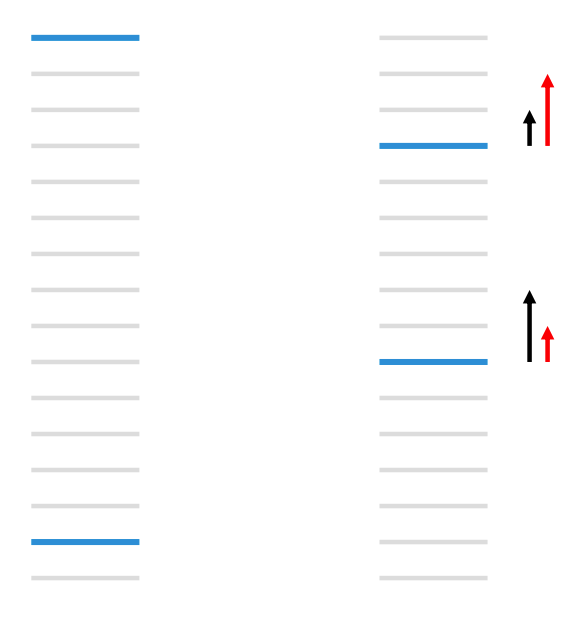

In [ ]:
def filter_candidates(original_product, candidates_df, constraints):
    """
    Filters a DataFrame of candidate products based on user-defined constraints for specific features.

    Parameters:
    - original_product (DataFrame): A DataFrame with a single row containing the original product's data.
      This serves as the reference for filtering.
    - candidates_df (DataFrame): A DataFrame containing candidate products to filter.
    - constraints (dict): A dictionary defining filtering rules for each feature.
        - Keys: Feature names (columns in the DataFrame).
        - Values: A tuple (preference, tolerance_percent), where:
            - preference (str): 'similar', 'higher', or 'lower', indicating how the feature should be compared.
            - tolerance_percent (float): The percentage tolerance for filtering based on the original product's feature value.
              Set to 0 if no tolerance is required.

    Returns:
    - DataFrame: A filtered DataFrame containing only candidates that meet the constraints.

    Example Usage:
    --------------
    # Define constraints for filtering
    constraints = {
        'carbohydrates': ('similar', 10),  # Allow 10% tolerance above/below the original value
        'nutrition-score-fr': ('higher', 5),  # Allow up to 5% higher than the original value
        'fat': ('lower', 10),  # Allow up to 10% lower than the original value
        'TRA-hgl': (True, 0)  # Filter to the same food category
    }

    # Completely unrestricted case
    constraints = {
      'carbohydrates': ('range', 0),
      'KCAL': ('range', 0),
      'energy': ('range', 0),
      'fat': ('range', 0),
      'sugars': ('range', 0),
      'fiber': ('range', 0),
      'proteins': ('range', 0),
      'salt': ('range', 0),
      'sodium': ('range', 0),
      'FSANZ-hgl': ('range', 0),
      'TRA-hgl': (True, 0)  # Filter to the same category (TRA-hgl matches original product)
    }

    # Filter candidate products
    filtered_candidates = filter_candidates(original_product, candidates_df, constraints)
    """
    for feature, (preference, tolerance_percent) in constraints.items():
        original_value = original_product[feature].values[0]

        # Special case for TRA-hgl (food category)
        if feature == 'TRA-hgl' and isinstance(preference, bool):
            if preference:  # True means filter to the same category
                candidates_df = candidates_df[candidates_df[feature] == original_value]
            continue  # Skip the rest of the filtering logic for TRA-hgl

        # General filtering for other features
        tolerance = abs(original_value * (tolerance_percent / 100)) if tolerance_percent > 0 else 0

        if preference == 'similar':
            # Select candidates within the range [original_value - tolerance, original_value + tolerance]
            lower_bound = original_value - tolerance
            upper_bound = original_value + tolerance
            candidates_df = candidates_df[
                (candidates_df[feature] >= lower_bound) & (candidates_df[feature] <= upper_bound)
            ]
        elif preference == 'higher':
            # Select candidates within the range [original_value, original_value + tolerance]
            lower_bound = original_value
            upper_bound = original_value + tolerance
            candidates_df = candidates_df[
                (candidates_df[feature] >= lower_bound) & (candidates_df[feature] <= upper_bound)
            ]
        elif preference == 'lower':
            # Select candidates within the range [original_value - tolerance, original_value]
            lower_bound = original_value - tolerance
            upper_bound = original_value
            candidates_df = candidates_df[
                (candidates_df[feature] >= lower_bound) & (candidates_df[feature] <= upper_bound)
            ]
    return candidates_df


### User-Defined Constraints for Filtering Recommendations

To generate meaningful recommendations, a set of user-defined constraints is applied:
- **Key Features**: Nutritional and categorical attributes such as `carbohydrates`, `fat`, `TRA-hgl`.
- **Filter Types**:
  - `'range'`: Allows recommendations to fall within a specified range around the original value.
  - `True/False` for `TRA-hgl`: Ensures category alignment with the original product.
- **Flexibility**: Relaxed constraints (`0` tolerance) enable inclusive recommendations.

### Shopping List Example

The `shopping_list` contains the product codes for items to analyze. For example:
- **Product Codes**: `33060` and `1938067`.

### KMeans Clustering

KMeans clustering divides products into groups based on similarity in their numerical features:
- **Cluster Count**: `10` clusters for this dataset.
- **Features Used**: Extracted from the dataset's numerical columns.

### LightGBM Ranker Configuration

To optimize the ranking model, the LightGBM ranker uses:
- **num_leaves**: Set to `31` to balance model complexity and generalization.


In [ ]:
# User-defined constraints for filtering recommendations
constraints = {
    'carbohydrates': ('range', 0),  # No constraint on carbohydrates
    'KCAL': ('range', 0),  # No constraint on calories
    'energy': ('range', 0),  # No constraint on energy
    'fat': ('range', 0),  # No constraint on fat
    'sugars': ('range', 0),  # No constraint on sugars
    'fiber': ('range', 0),  # No constraint on fiber
    'proteins': ('range', 0),  # No constraint on proteins
    'salt': ('range', 0),  # No constraint on salt
    'sodium': ('range', 0),  # No constraint on sodium
    'FSANZ-hgl': ('range', 0),  # No constraint on FSANZ health group level
    'TRA-hgl': (True, 0)  # Restrict to the same food category (TRA-hgl matches original product)
}

# Create a simple shopping list example
shopping_list = [72830008099, 0826766780785]# [33060, 1938067]  # Example with two product IDs as a shopping list

# Construct the `X_all` feature matrix
X_numeric_all = torch.tensor(food_fact_df[numeric_columns].fillna(0).values, dtype=torch.float32).numpy()

# Apply KMeans clustering to group all products
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_numeric_all)  # Perform clustering on all numerical features
y_for_model = y_tensor + abs(min(y_tensor)) + 1

# Define the list of columns for display
print_list = ['code', 'product_name', 'brands', 'carbohydrates', 'nutrition-score-fr', 'KCAL',
              'energy', 'fat', 'sugars', 'fiber', 'proteins', 'salt', 'sodium', 'FSANZ-hgl', 'TRA-hgl']

# Number of leaves for LightGBM Ranker
num_leaves = 64

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-33-00248cf018dd>, line 17)

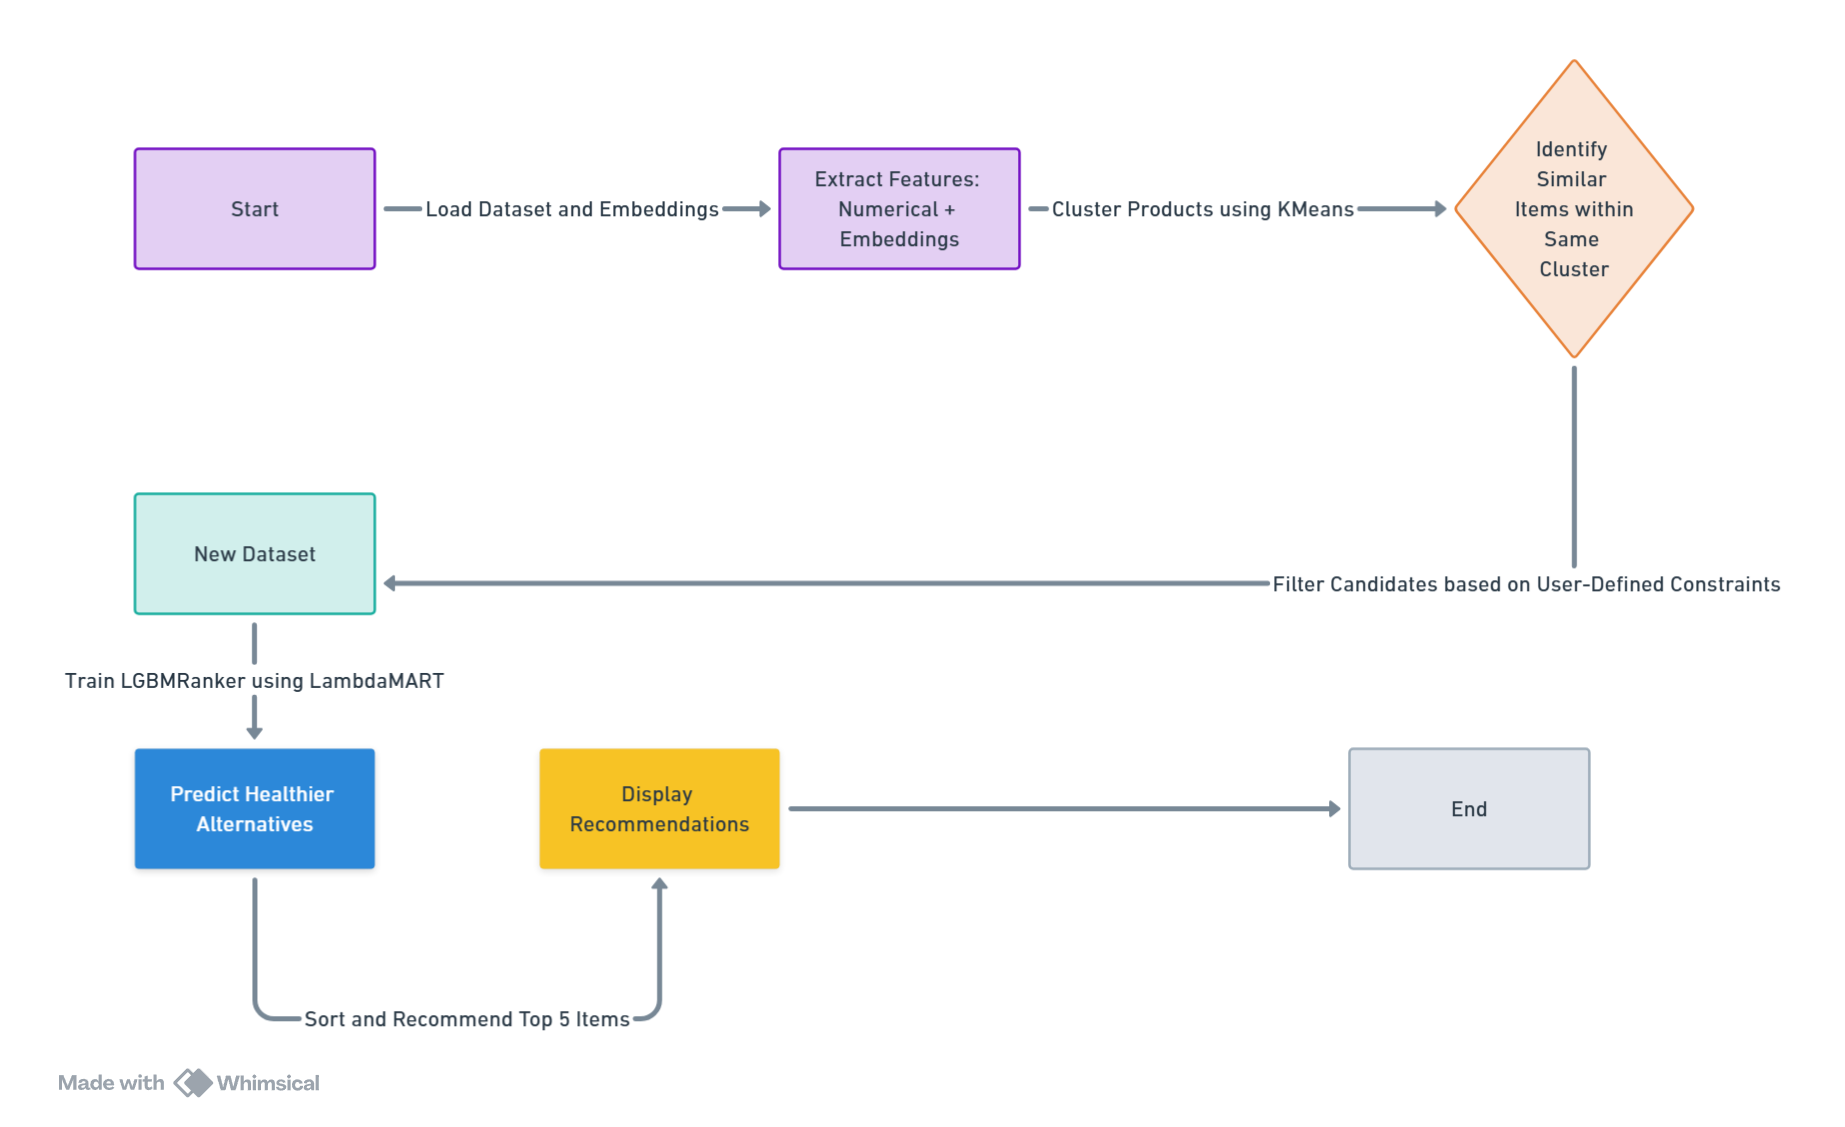

In [ ]:
# Loop through each product code in the shopping list
for product_code in shopping_list:
    # Identify the product's index in the dataset
    test_index = food_fact_df[food_fact_df['code'] == product_code].index

    # If the product code is not found, skip to the next item
    if test_index.empty:
        print(f"No matching product found in food_fact_df for product code {product_code}.")
        continue

    # Display information about the original product
    original_product_df = food_fact_df.loc[test_index]
    print("="*60, "Original Product:", "="*60)
    display(original_product_df[print_list])

    # Extract features for the test product for clustering
    X_test_numeric = X_numeric_all[test_index].reshape(1, -1)

    # Identify the cluster to which the product belongs
    cluster_label = kmeans.predict(X_test_numeric)[0]

    # Find indices of all items in the same cluster
    similar_items_indices = np.where(kmeans.labels_ == cluster_label)[0]

    # Ensure indices are valid and exclude the original product
    similar_items_indices = [idx for idx in similar_items_indices if 0 <= idx < len(X_numeric_all)]
    similar_items_indices = [idx for idx in similar_items_indices if idx not in test_index]

    # Retrieve details for similar products
    similar_items_df = food_fact_df.loc[similar_items_indices]

    # Apply user-defined filtering constraints
    print("Number of similar items before filtering:", len(similar_items_indices))
    filtered_similar_items_df = filter_candidates(original_product_df, similar_items_df, constraints)
    print("Number of filtered similar items:", len(filtered_similar_items_df))
    filtered_similar_items_indices = filtered_similar_items_df.index.tolist()

    # Skip if no items meet the filtering criteria
    if not filtered_similar_items_indices:
        print("No filtered similar items found for the original product.")
        continue

    # Limit the number of similar items for training
    max_limit = 10000
    if len(filtered_similar_items_indices) > max_limit:
        filtered_similar_items_indices = filtered_similar_items_indices[:max_limit]

    # Prepare data for LightGBM ranking
    X_train_similar = X_numeric_all[filtered_similar_items_indices]  # Features for similar products
    y_train_similar = y_for_model[filtered_similar_items_indices]  # Target values for similar products
    group_train_similar = [len(X_train_similar)]  # Group all similar products together

    # Normalize target values for LightGBM
    y_train_similar = (y_train_similar - y_train_similar.min()) / (y_train_similar.max() - y_train_similar.min())  # Add small value to avoid division by zero
    y_train_similar = (y_train_similar * (num_leaves - 1)).to(torch.int)  # Scale to [0, num_leaves - 1]
    y_train_similar = torch.clamp(y_train_similar, 0, num_leaves - 1)  # Ensure no value exceeds range
    y_train_similar = y_train_similar.numpy().squeeze()  # Convert to NumPy
    y_train_similar = y_train_similar.tolist()  # Convert to list

    # Dynamically create label_gain based on max label value
    max_label_value = int(max(y_train_similar))
    label_gain = list(range(max_label_value + 1))  # Gain = label value (linear mapping)

    ranker = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        num_leaves=num_leaves,  # Dynamically adjusted
        learning_rate=0.01,
        n_estimators=100,
        feature_fraction=0.8,
        label_gain=label_gain,  # Pass the customized label_gain
        verbose=-1
    )

    ranker.fit(
        X_train_similar, y_train_similar,
        group=group_train_similar,
        eval_set=[(X_numeric_all[test_index], y_for_model[test_index].numpy())],
        eval_group=[[1]],  # Single test product for evaluation
        eval_at=[5]
    )

    # Predict scores for the filtered similar products
    y_pred = ranker.predict(X_train_similar)
    # Manually override sorting based on actual nutrition-score-fr
    nutrition_scores = food_fact_df.loc[filtered_similar_items_indices, 'nutrition-score-fr'].values

    # Create a combined array with both predicted scores and actual nutrition scores
    combined_scores = list(zip(filtered_similar_items_indices, y_pred, nutrition_scores))

    # Sort first by nutrition-score-fr (ascending), then by y_pred (descending)
    sorted_combined = sorted(combined_scores, key=lambda x: (x[2], -x[1]))

    # Select top 5 recommended indices based on sorted results
    recommended_indices = [item[0] for item in sorted_combined[:5]]

    # y_pred = ranker.predict(X_train_similar)
    # print(f"Predicted scores for similar products for comparison with product code {product_code}.")

    # # 对结果进行排序，推荐更健康的替代品（得分更高）
    # sorted_indices = np.argsort(-y_pred)  # 降序排列得分
    # recommended_indices = [similar_items_indices[idx] for idx in sorted_indices[:5]]  # 获取前5个推荐商品

    # Display the recommended products
    if recommended_indices:
        recommended_df = food_fact_df.loc[recommended_indices]
        print("Recommended Healthier Alternatives for the Product:")
        display(recommended_df[print_list])
    else:
        print("No recommendations available.")

============================================================ Original Product: ============================================================


,code,product_name,brands,carbohydrates,nutrition-score-fr,KCAL,energy,fat,sugars,fiber,proteins,salt,sodium,FSANZ-hgl,TRA-hgl
39373,72830008099,Swiss Natural Cheese,Tillamook,3.57,16.0,393.301435,1644.0,28.57,0.0,0.0,32.14,0.54356,0.214,20.042192,4.0


Number of similar items before filtering: 14368
Number of filtered similar items: 1352
Recommended Healthier Alternatives for the Product:


,code,product_name,brands,carbohydrates,nutrition-score-fr,KCAL,energy,fat,sugars,fiber,proteins,salt,sodium,FSANZ-hgl,TRA-hgl
85702,3222471962558,Lentilles vertes Bio,"Casino,Casino Bio",33.0,-12.0,299.282297,1251.0,1.3,2.1,25.0,26.0,0.025400,0.010000,-14.958205,4.0
96515,3700036900295,Lentilles vertes,Naturalia,28.5,-12.0,295.933014,1237.0,1.7,1.5,32.0,25.5,0.010160,0.004000,-15.398997,4.0
95070,3564707091756,Lentilles vertes Bio - 500 g - Bio Village,"Bio Village,Marque repère",57.0,-11.0,373.205742,1560.0,1.0,1.0,10.4,28.0,0.050000,0.019685,-12.289851,4.0
90876,3270190128403,Lentilles vertes Bio,"Carrefour,Carrefour bio",50.0,-11.0,337.081340,1409.0,1.7,1.0,11.0,24.0,0.010008,0.003940,-12.219353,4.0
94471,3560071052133,Lentilles corail,Carrefour bio,50.0,-11.0,333.253589,1393.0,1.7,1.0,11.0,25.0,0.000000,0.000000,-12.058880,4.0
